In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
dataset_path = '/content/drive/MyDrive/dataset.csv'
df = pd.read_csv(dataset_path, nrows=1000)
df.head(1)

,text,summary
0,long term synaptic plasticity thought represen...,understanding spatiotemporal organization long...


In [ ]:
article_length = len(df['text'][0])
abstract_length = len(df['summary'][0])
print(f"Length of article: {article_length}")
print(f"Length of abstract: {abstract_length}")


Length of article: 22492
Length of abstract: 1117


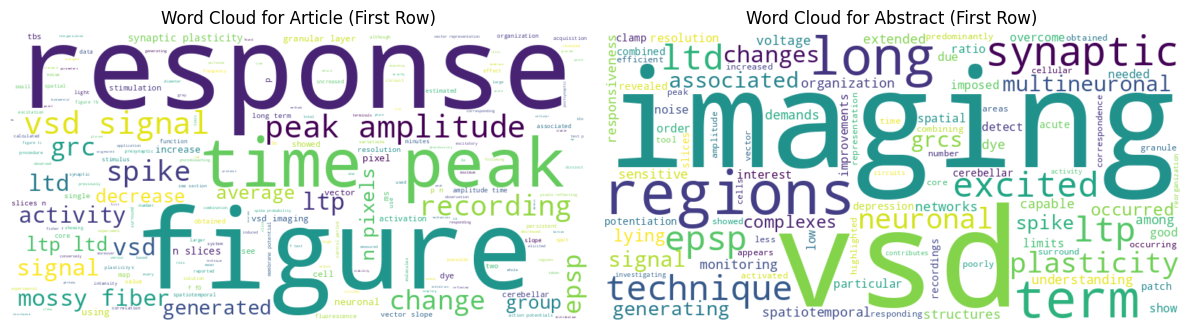

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

first_article = df['text'][0]
first_abstract = df['summary'][0]

article_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(first_article)

abstract_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(first_abstract)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(article_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Article (First Row)')

plt.subplot(1, 2, 2)
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Abstract (First Row)')

plt.tight_layout()
plt.show()

In [ ]:
import re

def remove_urls(text):
    if isinstance(text, str):
        return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    return text

df['text'] = df['text'].astype(str).apply(remove_urls)
df['summary'] = df['summary'].astype(str).apply(remove_urls)

print("URLs removed, numbers and other text retained.")

URLs removed, numbers and other text retained.


In [ ]:
def remove_special_characters(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text'] = df['text'].astype(str).apply(remove_special_characters)
df['summary'] = df['summary'].astype(str).apply(remove_special_characters)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        words = [word for word in words if word.lower() not in stop_words]
        return ' '.join(words)
    return text

df['text'] = df['text'].astype(str).apply(remove_stopwords)
df['summary'] = df['summary'].astype(str).apply(remove_stopwords)

In [ ]:
def remove_extra_spaces(text):
    if isinstance(text, str):
        return ' '.join(text.split())
    return text  # Return unchanged if not a string

df['text'] = df['text'].astype(str).apply(remove_extra_spaces)
df['summary'] = df['summary'].astype(str).apply(remove_extra_spaces)

In [ ]:
def to_lowercase(text):
    if isinstance(text, str):
        return text.lower()
    return text


df['text'] = df['text'].astype(str).apply(to_lowercase)
df['summary'] = df['summary'].astype(str).apply(to_lowercase)

In [ ]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

text = [str(doc) for doc in nlp.pipe(df['text'], batch_size=100)]

summary = ['_START_ ' + str(doc) + ' _END_' for doc in nlp.pipe(df['summary'], batch_size=100)]

In [ ]:
df['cleaned_article'] = pd.Series(text)
df['cleaned_abstract'] = pd.Series(summary)

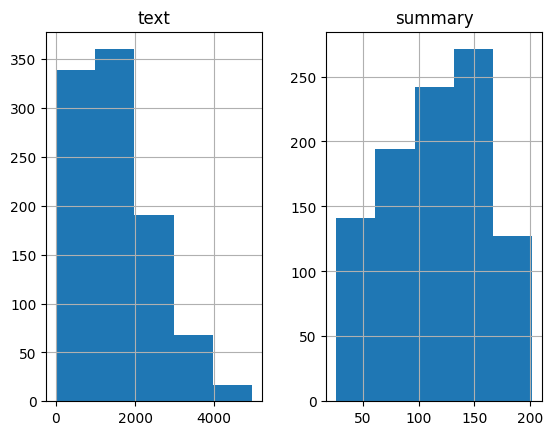

In [ ]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in df['cleaned_article']:
    text_count.append(len(sent.split()))

for sent in df['cleaned_abstract']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [ ]:
cnt = 0
for i in df['cleaned_article']:
    if len(i.split()) <= 5000:
        cnt = cnt + 1
print(cnt / len(df['cleaned_article']))

1.0


In [ ]:
cnt = 0
for i in df['cleaned_abstract']:
    if len(i.split()) <= 200:
        cnt = cnt + 1
print(cnt / len(df['cleaned_abstract']))

0.9989743589743589


In [ ]:
max_len_article = 5000
max_len_abstract = 200

In [ ]:
cleaned_text = np.array(df['cleaned_article'])
cleaned_summary= np.array(df['cleaned_abstract'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_len_abstract and len(cleaned_text[i].split()) <= max_len_article:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

new_df = pd.DataFrame({'text': short_text,'summary': short_summary})

new_df.head(1)

,text,summary
0,long term synaptic plasticity thought represen...,_START_ understanding spatiotemporal organizat...


In [ ]:
new_df.shape


(974, 2)

In [ ]:
new_df['summary'] = new_df['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')

new_df.head(1)

,text,summary
0,long term synaptic plasticity thought represen...,sostok _START_ understanding spatiotemporal or...


In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(new_df["text"]),
    np.array(new_df["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  68.25440573272158


In [ ]:
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

x_tr = pad_sequences(x_tr_seq,  maxlen=max_len_article, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_len_article, padding='post')

x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 19582


In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 75.49126637554585


In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

y_tr = pad_sequences(y_tr_seq, maxlen=max_len_abstract, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_len_abstract, padding='post')

y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 4042


In [ ]:
import pickle

with open('/content/drive/MyDrive/saved_model/x_tokenizer.pkl', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/saved_model/y_tokenizer.pkl', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizers saved successfully.")


Tokenizers saved successfully.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_len_article, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 5000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 5000, 200)      │      3,916,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 5000, 300),    │        601,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 5000, 300),    │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │        808,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 5000, 300),    │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        601,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 4042)     │      1,216,642 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,586,242 (32.75 MB)

 Trainable params: 8,586,242 (32.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=30,
    callbacks=[es],
    batch_size=32,
    validation_data=([x_val, y_val[:, :-1]],

                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 977s 34s/step - loss: 6.3645 - val_loss: 3.4235
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 972s 34s/step - loss: 3.7975 - val_loss: 3.1658
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 989s 34s/step - loss: 3.5918 - val_loss: 3.1178
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 973s 34s/step - loss: 3.5619 - val_loss: 3.0984
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1012s 35s/step - loss: 3.5216 - val_loss: 3.0867
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 948s 34s/step - loss: 3.5114 - val_loss: 3.0768
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 982s 34s/step - loss: 3.5553 - val_loss: 3.0699
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 987s 34s/step - loss: 3.5602 - val_loss: 3.0653
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 981s 34s/step - loss: 3.4241 - val_loss: 3.0589
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 950s 34s/step - loss: 3.4764 - val_loss: 3.0498
Epoch 11/30


KeyboardInterrupt: 

In [ ]:
import numpy as np

data_path = '/content/drive/MyDrive/saved_model/'

# Sauvegarder les données traitées
np.save(data_path + 'x_tr.npy', x_tr)
np.save(data_path + 'y_tr.npy', y_tr)
np.save(data_path + 'x_val.npy', x_val)
np.save(data_path + 'y_val.npy', y_val)

print("Données sauvegardées avec succès.")

Données sauvegardées avec succès.


In [ ]:
model_path = '/content/drive/MyDrive/saved_model/seq2seq_model.keras'
model.save(model_path)

print("Modèle complet sauvegardé avec succès.")

Modèle complet sauvegardé avec succès.


In [ ]:
import json

config = {
    "max_len_article": max_len_article,
    "max_len_abstract": max_len_abstract,
    "x_voc": x_voc,
    "y_voc": y_voc,
    "latent_dim": latent_dim,
    "embedding_dim": embedding_dim
}

# Sauvegarder les configurations
with open('/content/drive/MyDrive/saved_model/config.json', 'w') as f:
    json.dump(config, f)

print("Configurations saved successfully.")


Configurations saved successfully.
